In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
N = 1000
p = 300
T = 120
idiovol_sigma = np.sqrt(0.3*0.3/12)
e_mu = np.sqrt(0.2*0.2/12)
e_sigma = e_mu
mu = 0.1/12/e_mu
a = 1.5
b = 1.5
w0 = np.zeros(N) # for now
returns = []

# values_new = []

values_new = []

# X
factors = []
# y
y = []

# Save different samples through different simulations


for s in range(100): # can change the simulation number
    beta = np.zeros((N,p)) 
    beta[:,0] = e_mu
    mus = np.zeros((N,p))
    mus[:,0] = mu
    returns = []
    fs = []
    for j in range(1,p):
        beta[:,j-1] = e_mu*j**(-a)  # draw an N*p matrix of beta
        mus[:,j-1] = mu*j**(-b)  # draw an N*p matrix of mus
    alpha = (beta * mus).sum(axis = 1) # get the factor risk premia
#     beta_hat_stocks = [] # to store the betas for each stock after their ridge regression
#     alpha_hat_stocks = [] # to store the alphas for each stock after their ridge regression
#     sigma_ridge = []
    for stock in range(N):
        f = np.random.multivariate_normal(np.zeros(p), np.identity(p), T) # for each stock generate the factor matrix
        epsilon = np.random.normal(0,idiovol_sigma,T) #generate the residuals
        r = alpha[stock] + np.array(beta[stock]).T @ f.T + epsilon # calculate the return series for each stock
        returns.append(r.T)
        fs.append(f)
        
    y.append(returns) 
    factors.append(fs)
 

In [30]:
np.shape(y[0][0]) # the first simulation for stock 1


(120,)

In [31]:
np.shape(factors[1][2]) # every simulation has 500 T*p matrices; this is the factor matrix for stock 3 on simulation 2


(120, 300)

In [6]:
gamma = 1
c = 1

In [26]:
# test different utility vs different lambdas
lambdas = np.geomspace(1,500,20)
# utility = np.zeros((len(lambdas),100)) # 100 = simulation times
# beta_ridge = []
# alpha_ridge = []

utility_avg = []
for l in lambdas:
    value_l = []
    for s in range(np.shape(y)[0]):
        beta_hat_stocks = []
        alpha_hat_stocks = []
        sigma_ridge = []
        for stock in range(N):
            ridge = Ridge(alpha = l, fit_intercept=True)
            ridge.fit(factors[s][stock], y[s][stock])
            beta_hat_stocks.append(ridge.coef_)
            alpha_hat_stocks.append(ridge.intercept_)
            sigma_ridge.append(np.var(r - ridge.intercept_ - ridge.coef_ @ f.T))
        sigma_hat = np.array(beta_hat_stocks) @ np.array(beta_hat_stocks).T + sigma_ridge @ np.identity(N)
        weights = np.linalg.inv(gamma * sigma_hat + c * np.identity(N)) @ (alpha_hat_stocks + c * w0)
        sigma_true = beta @ beta.T + np.identity(N)*idiovol_sigma**2 
        value = weights.T @ alpha - 0.5*gamma*weights.T @ sigma_true @ weights - 0.5*c*np.sqrt(sum((weights - w0)**2))
        value_l.append(value)
    utility_avg.append(np.mean(value_l))

Text(0.5, 0, 'Lambdas')

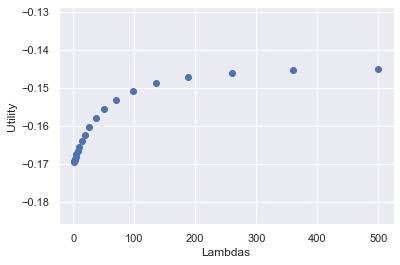

In [28]:
plt.scatter(y = utility_avg, x = lambdas)
plt.ylabel('Utility')
plt.xlabel('Lambdas')